# Xopt Evaluator Basic Usage 

The `Evaluator` handles the execution of the user-provided `function` with optional `function_kwags`, asyncrhonously and parallel, with exception handling. 

In [1]:
# needed for macos
import platform
if platform.system() == "Darwin": import multiprocessing;multiprocessing.set_start_method("fork")


In [2]:
from xopt import Xopt, Evaluator, VOCS
from xopt.generators.random import RandomGenerator

import pandas as pd

from time import sleep
from numpy.random import randint

from typing import Dict

import numpy as np
np.random.seed(666) # for reproducibility

Define a custom function `f(inputs: Dict) -> outputs: Dict`. 

In [3]:
def f(inputs: Dict, enable_errors=True) -> Dict:

    sleep(randint(1, 5)*.1)  # simulate computation time
    # Make some occasional errors
    if enable_errors and np.any(inputs["x"] > 0.8):
        raise ValueError("x > 0.8")

    return {"f1": inputs["x"] ** 2 + inputs["y"] ** 2}

Define variables, objectives, constraints, and other settings (VOCS)

In [4]:
vocs = VOCS(variables={"x": [0, 1], "y": [0, 1]}, objectives={"f1": "MINIMIZE"})
vocs



VOCS(variables={'x': [0.0, 1.0], 'y': [0.0, 1.0]}, constraints={}, objectives={'f1': 'MINIMIZE'}, constants={}, observables=[])

This can be used to make some random inputs for evaluating the function. 

In [5]:
in1 = vocs.random_inputs()[0]

f(in1, enable_errors=False)

{'f1': array([0.11401572])}

In [6]:
# Add in occasional errors. 
try:
    f({"x": 1, "y": 0})
except Exception as ex:
    print(f"Caught error in f: {ex}")

Caught error in f: x > 0.8


In [7]:
# Create Evaluator
ev = Evaluator(function=f)

In [8]:
# Single input evaluation
ev.evaluate(in1)

{'f1': array([0.11401572]),
 'xopt_runtime': 0.2005029229999309,
 'xopt_error': False}

In [9]:
# Dataframe evaluation
in10 = pd.DataFrame({
    "x":np.linspace(0,1,10),
    "y":np.linspace(0,1,10)
})
ev.evaluate_data(in10)


,f1,xopt_runtime,xopt_error,xopt_error_str
0,0.000000,0.300603,False,NaN
1,0.024691,0.100444,False,NaN
2,0.098765,0.200465,False,NaN
3,0.222222,0.400717,False,NaN
4,0.395062,0.300613,False,NaN
5,0.617284,0.400637,False,NaN
6,0.888889,0.100404,False,NaN
7,1.209877,0.400682,False,NaN
8,NaN,0.100905,True,"Traceback (most recent call last):\n File ""/u..."
9,NaN,0.300749,True,"Traceback (most recent call last):\n File ""/u..."


In [10]:
# Dataframe evaluation, vectorized
ev.vectorized = True
ev.evaluate_data(in10)


,xopt_runtime,xopt_error,xopt_error_str
0,0.201635,True,"Traceback (most recent call last):\n File ""/u..."
1,0.201635,True,"Traceback (most recent call last):\n File ""/u..."
2,0.201635,True,"Traceback (most recent call last):\n File ""/u..."
3,0.201635,True,"Traceback (most recent call last):\n File ""/u..."
4,0.201635,True,"Traceback (most recent call last):\n File ""/u..."
5,0.201635,True,"Traceback (most recent call last):\n File ""/u..."
6,0.201635,True,"Traceback (most recent call last):\n File ""/u..."
7,0.201635,True,"Traceback (most recent call last):\n File ""/u..."
8,0.201635,True,"Traceback (most recent call last):\n File ""/u..."
9,0.201635,True,"Traceback (most recent call last):\n File ""/u..."


# Executors

In [11]:
from concurrent.futures import ProcessPoolExecutor
MAX_WORKERS = 10

In [12]:
# Create Executor instance
executor = ProcessPoolExecutor(max_workers=MAX_WORKERS)
executor

In [13]:
# Dask (Optional)
# from dask.distributed import Client
# import logging
# client = Client( silence_logs=logging.ERROR)
# executor = client.get_executor()
# client

In [14]:
# This calls `executor.map`
ev = Evaluator(function=f, executor=executor, max_workers=MAX_WORKERS)

In [15]:
# This will run in parallel
ev.evaluate_data(in10)

,f1,xopt_runtime,xopt_error,xopt_error_str
0,0.000000,0.401144,False,NaN
1,0.024691,0.401074,False,NaN
2,0.098765,0.401647,False,NaN
3,0.222222,0.401119,False,NaN
4,0.395062,0.401712,False,NaN
5,0.617284,0.401359,False,NaN
6,0.888889,0.401571,False,NaN
7,1.209877,0.401342,False,NaN
8,NaN,0.402389,True,"Traceback (most recent call last):\n File ""/u..."
9,NaN,0.402068,True,"Traceback (most recent call last):\n File ""/u..."


# Evaluator in the Xopt object

In [16]:
X = Xopt(generator=RandomGenerator(vocs=vocs), evaluator=Evaluator(function=f),
         vocs=vocs)
X.strict = False

# Evaluate to the evaluator some new inputs
X.evaluate_data(X.vocs.random_inputs(4))


,x,y,f1,xopt_runtime,xopt_error,xopt_error_str
0,0.491934,0.299155,0.331493,0.100377,False,NaN
1,0.799752,0.706772,1.139131,0.100337,False,NaN
2,0.255846,0.225521,0.116317,0.100380,False,NaN
3,0.807108,0.994891,NaN,0.100893,True,"Traceback (most recent call last):\n File ""/u..."


## Asynchronous Xopt
Instead of waiting for evaluations to be finished, AsynchronousXopt can be used to generate candidates while waiting for other evaluations to finish (requires parallel execution). In this case, calling ```X.step()``` generates and executes a number of candidates that are executed in parallel using python ```concurrent.futures``` formalism. Calling ```X.step()``` again will generate and evaluate new points based on finished futures asynchronously.

In [17]:
# Usage with a parallel executor.
from xopt import AsynchronousXopt

executor = ProcessPoolExecutor(max_workers=MAX_WORKERS)

X2 = AsynchronousXopt(
    generator=RandomGenerator(vocs=vocs),
    evaluator=Evaluator(function=f, executor=executor, max_workers=MAX_WORKERS),
    vocs=vocs,
)
X2.strict = False

In [18]:
X2.step()

In [19]:
for _ in range(20):
    X2.step()

len(X2.data)

37

<Axes: xlabel='x', ylabel='y'>

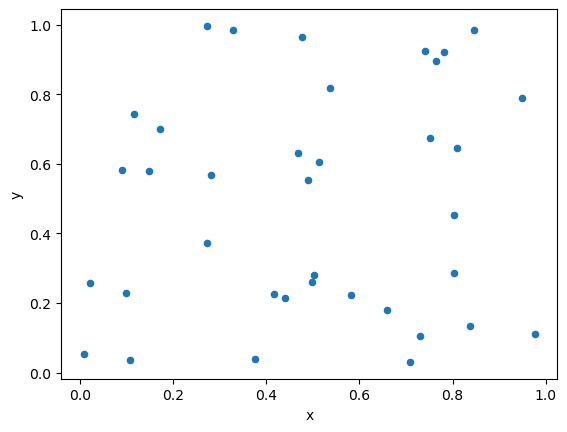

In [20]:
X2.data.plot.scatter("x", "y")

In [21]:
# Asynchronous, Vectorized
X2 = AsynchronousXopt(
    generator=RandomGenerator(vocs=vocs),
    evaluator=Evaluator(function=f, executor=executor, max_workers=MAX_WORKERS),
    vocs=vocs,
)
X2.evaluator.vectorized = True
X2.strict = False

# This takes fewer steps to achieve a similar number of evaluations
for _ in range(3):
    X2.step()

len(X2.data)

30